In [1]:
%matplotlib inline
import glob
import re
import json
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import stats
import seaborn as sns

mpl.rc('font', family='Arial', size=12)

In [2]:
with open('../../pair_counts.json') as f:
    total_read_counts = pd.Series({k: v/2e6 for k,v in json.load(f).items()})

In [3]:
spike_counts = pd.read_csv('../../spike_in_counts_bwa_minus_strand.tsv', sep = '\t', 
                           names = ('template', 'read_count', 'sample_name'))

spikein_matrix = (spike_counts.groupby(['sample_name', 'template']).read_count.mean().unstack().fillna(0) //2)
spikein_counts = pd.Series(spikein_matrix.loc[:, ['H281', 'L286']].mean(axis=1))

In [4]:
spikein_matrix.loc[['dmso_2', 'dmso_3']]

template,H136,H281,HDNA,L132,L286,LDNA,ssDNA
sample_name,,,,,,,
dmso_2,194.0,1252.0,15.0,60.0,676.0,-0.0,-0.0
dmso_3,365.0,1810.0,6.0,96.0,1036.0,2.0,-0.0


In [5]:
def ucsc_index(df):
    return df.chr.str.cat(df.start.astype(str).str.cat(df.end.astype(str), sep='-'), sep=':')

In [6]:
dmso_calls_total_norm = pd.read_csv('../../count_statistics/new_macs_calls/Deseq_calls_dmso_new_peaks_total_reads.tsv', sep='\t')
dmso_calls_spikein_norm = pd.read_csv('../../count_statistics/new_macs_calls/Deseq_calls_dmso_new_peaks.tsv', sep='\t')
read_counts_dmso = pd.read_csv('../../count_statistics/new_macs_calls/dmso_deseq_matrix_dmso_drb_random.tsv', index_col=0, sep='\t')
read_counts_dmso = read_counts_dmso.iloc[:-3, :]
all_counts = pd.read_csv('../../count_statistics/new_macs_calls/all_counts_dmso_drb_random.tsv', sep='\t', index_col=0)


In [7]:
used_counts = all_counts.drop(['gl3_1', 'aqr_1', 'mcm_1', 'drb_1', 'dmso_1'], axis = 1)

In [8]:
def volcano_plot(df, ax):
    ax.scatter(df.log2FoldChange, -np.log10(df.padj))

Text(0.5,1,'Calls with spikein normalization')

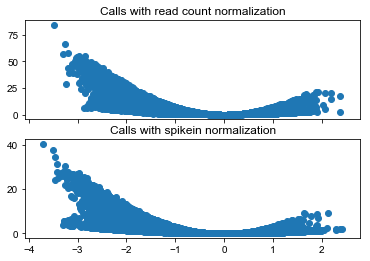

In [9]:
fig, ax = plt.subplots(nrows = 2, sharex=True)

volcano_plot(dmso_calls_total_norm, ax[0])
volcano_plot(dmso_calls_spikein_norm, ax[1])

ax[0].set_title('Calls with read count normalization')
ax[1].set_title('Calls with spikein normalization')

In [10]:
spikein_counts

sample_name
aqr_1       749.0
aqr_2      1228.5
aqr_3      2021.5
aqr_in        2.5
aqr_rh       85.0
dmso_1       37.0
dmso_2      964.0
dmso_3     1423.0
dmso_in       5.5
drb_1        91.5
drb_2      1596.5
drb_3      1439.5
drb_rh       62.0
gl3_1        26.0
gl3_2       898.0
gl3_3      1288.0
gl3_in        3.0
gl3_rh       84.5
mcm_1      1595.0
mcm_2      1429.0
mcm_3      1856.0
mcm_in        7.0
mcm_rh       69.5
dtype: float64

In [11]:
lengths = all_counts.index.str.extract(':(\d+)-(\d+)', expand=True).rename(columns={0:'start', 1:'end'})
lengths = (pd.to_numeric(lengths.end , errors='coerce')- pd.to_numeric(lengths.start, errors='coerce'))/1e3

In [12]:
lengths.index = all_counts.index

In [13]:
def mean_norm_counts(df, sample_name, norm_type='rpm'):
    relevant_colnames = list(df.columns[df.columns.str.contains(sample_name)])
    relevant_cols = df[relevant_colnames].copy()
    if norm_type == 'rpm':
        relevant_cols = (relevant_cols +1) / total_read_counts[relevant_colnames]
    elif norm_type == 'spikein':
        relevant_cols = (relevant_cols +1) / spikein_counts[relevant_colnames]
    return relevant_cols.mean(axis=1)

In [14]:
def mean_norm_counts_length(df, sample_name, norm_type='rpm'):
    relevant_colnames = list(df.columns[df.columns.str.contains(sample_name)])
    
    relevant_cols = df[relevant_colnames].copy()
    if norm_type == 'rpm':
        relevant_cols = (relevant_cols +1) / total_read_counts[relevant_colnames]
    elif norm_type == 'spikein':
        relevant_cols = (relevant_cols +1) / spikein_counts[relevant_colnames]
    return relevant_cols.mean(axis=1)/lengths

In [15]:
len(read_counts_dmso)

179211

In [16]:

mask_up = (dmso_calls.padj < 0.1) & (dmso_calls.log2FoldChange > 0)
mask_down = (dmso_calls.padj < 0.1) & (dmso_calls.log2FoldChange < 0)
mask_up_norm = (dmso_calls_norm.padj < 0.1) & (dmso_calls_norm.log2FoldChange > 0)
mask_down_norm = (dmso_calls_norm.padj < 0.1) & (dmso_calls_norm.log2FoldChange < 0)


NameError: name 'dmso_calls' is not defined

Text(0.5,1,'Spike-in normalized')

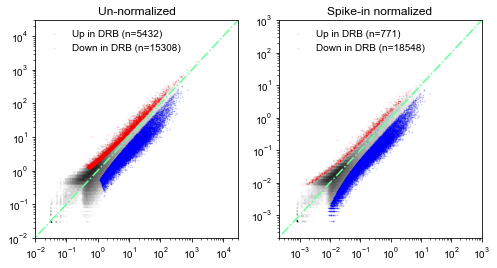

In [17]:
fig, ax = plt.subplots(figsize=(8,4), ncols = 2)

ax[0].hexbin(mean_norm_counts(read_counts_dmso, 'dmso'), 
          mean_norm_counts(read_counts_dmso, 'drb'), 
          cmap = 'Greys', bins = 'log', xscale = 'log',
          yscale = 'log'
         )

ax[1].hexbin(mean_norm_counts(read_counts_dmso, 'dmso', norm_type='spikein'), 
          mean_norm_counts(read_counts_dmso, 'drb', norm_type='spikein'), 
          cmap = 'Greys', bins = 'log', xscale = 'log',
          yscale = 'log'
         )

mask_up = (dmso_calls_total_norm.padj < 0.1) & (dmso_calls_total_norm.log2FoldChange > 0)
mask_down = (dmso_calls_total_norm.padj < 0.1) & (dmso_calls_total_norm.log2FoldChange < 0)
mask_up_norm = (dmso_calls_spikein_norm.padj < 0.1) & (dmso_calls_spikein_norm.log2FoldChange > 0)
mask_down_norm = (dmso_calls_spikein_norm.padj < 0.1) & (dmso_calls_spikein_norm.log2FoldChange < 0)

ax[0].scatter(mean_norm_counts(read_counts_dmso, 'dmso')[mask_up],
              mean_norm_counts(read_counts_dmso, 'drb')[mask_up],
              color = 'red', label = f'Up in DRB (n={mask_up.sum()})', s = 0.2, alpha=0.2
             )

ax[0].scatter(mean_norm_counts(read_counts_dmso, 'dmso')[mask_down],
              mean_norm_counts(read_counts_dmso, 'drb')[mask_down],
              color = 'blue', label = f'Down in DRB (n={mask_down.sum()})', s = 0.2, alpha=0.2
             )

ax[1].scatter(mean_norm_counts(read_counts_dmso, 'dmso', norm_type='spikein')[mask_up_norm],
              mean_norm_counts(read_counts_dmso, 'drb', norm_type='spikein')[mask_up_norm],
              color = 'red', label = f'Up in DRB (n={mask_up_norm.sum()})', s = 0.2, alpha=0.2
             )

ax[1].scatter(mean_norm_counts(read_counts_dmso, 'dmso', norm_type='spikein')[mask_down_norm],
              mean_norm_counts(read_counts_dmso, 'drb', norm_type='spikein')[mask_down_norm],
              color = 'blue', label = f'Down in DRB (n={mask_down_norm.sum()})', s = 0.2, alpha=0.2
             )

for a in ax:
    a.plot([0,1e5], [0, 1e5], color = '#66ff99', linestyle='-.')
    
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
    
ax[0].set_xlim(1e-2, 3e4)
ax[0].set_ylim(1e-2, 3e4)

ax[1].set_xlim(2e-4, 1e3)
ax[1].set_ylim(2e-4, 1e3)

ax[0].set_title('Un-normalized')
ax[1].set_title('Spike-in normalized')

In [ ]:
fig, ax = plt.subplots(figsize=(8,4), ncols = 2)

ax[0].hexbin(mean_norm_counts(read_counts_dmso, 'dmso'), 
          mean_norm_counts(read_counts_dmso, 'drb'), 
          cmap = 'Greys', bins = 'log', xscale = 'log',
          yscale = 'log'
         )

ax[1].hexbin(mean_norm_counts(read_counts_dmso, 'dmso', norm_type='spikein'), 
          mean_norm_counts(read_counts_dmso, 'drb', norm_type='spikein'), 
          cmap = 'Greys', bins = 'log', xscale = 'log',
          yscale = 'log'
         )

mask_up = (dmso_calls_total_norm.padj < 0.1) & (dmso_calls_total_norm.log2FoldChange > 0)
mask_down = (dmso_calls_total_norm.padj < 0.1) & (dmso_calls_total_norm.log2FoldChange < 0)
mask_up_norm = (dmso_calls_spikein_norm.padj < 0.1) & (dmso_calls_spikein_norm.log2FoldChange > 0)
mask_down_norm = (dmso_calls_spikein_norm.padj < 0.1) & (dmso_calls_spikein_norm.log2FoldChange < 0)

ax[0].scatter(mean_norm_counts(read_counts_dmso, 'dmso')[mask_up],
              mean_norm_counts(read_counts_dmso, 'drb')[mask_up],
              color = 'red', label = f'Up in DRB (n={mask_up.sum()})', s = 0.2, alpha=0.2
             )

ax[0].scatter(mean_norm_counts(read_counts_dmso, 'dmso')[mask_down],
              mean_norm_counts(read_counts_dmso, 'drb')[mask_down],
              color = 'blue', label = f'Down in DRB (n={mask_down.sum()})', s = 0.2, alpha=0.2
             )

ax[1].scatter(mean_norm_counts(read_counts_dmso, 'dmso', norm_type='spikein')[mask_up_norm],
              mean_norm_counts(read_counts_dmso, 'drb', norm_type='spikein')[mask_up_norm],
              color = 'red', label = f'Up in DRB (n={mask_up_norm.sum()})', s = 0.2, alpha=0.2
             )

ax[1].scatter(mean_norm_counts(read_counts_dmso, 'dmso', norm_type='spikein')[mask_down_norm],
              mean_norm_counts(read_counts_dmso, 'drb', norm_type='spikein')[mask_down_norm],
              color = 'blue', label = f'Down in DRB (n={mask_down_norm.sum()})', s = 0.2, alpha=0.2
             )

for a in ax:
    a.plot([0,1e5], [0, 1e5], color = '#66ff99', linestyle='-.')
    
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
    
ax[0].set_xlim(1e-2, 3e4)
ax[0].set_ylim(1e-2, 3e4)

ax[1].set_xlim(2e-4, 1e3)
ax[1].set_ylim(2e-4, 1e3)

ax[0].set_title('Un-normalized')
ax[1].set_title('Spike-in normalized')

# Report significantly changed peaks

In [18]:
filtered_peaks = pd.read_csv('../../peak_calls/combined_bam_peaks/combined_broad_consensus_rh_and_strand_filtered.bed',
                             sep = '\t', names = ('chr', 'start', 'end', 'name', 'value', 'strand')
                            )

In [19]:
filtered_peaks['name'] = ucsc_index(filtered_peaks)

In [20]:
filtered_peaks.head()

,chr,start,end,name,value,strand
0,chr1,1328847,1337532,chr1:1328847-1337532,.,-
1,chr1,1829772,1830294,chr1:1829772-1830294,.,-
2,chr1,1856627,1858640,chr1:1856627-1858640,.,-
3,chr1,2357985,2358619,chr1:2357985-2358619,.,-
4,chr1,2390322,2390795,chr1:2390322-2390795,.,+


In [18]:
mask_up = (dmso_calls_total_norm.padj < 0.1) & (dmso_calls_total_norm.log2FoldChange > 0)
mask_down = (dmso_calls_total_norm.padj < 0.1) & (dmso_calls_total_norm.log2FoldChange < 0)
mask_up_norm = (dmso_calls_spikein_norm.padj < 0.1) & (dmso_calls_spikein_norm.log2FoldChange > 0)
mask_down_norm = (dmso_calls_spikein_norm.padj < 0.1) & (dmso_calls_spikein_norm.log2FoldChange < 0)

filtered_peaks.loc[filtered_peaks.name.isin(set(all_counts[mask_up].index)), 
                   ['chr', 'start', 'end']].to_csv('../../peak_calls/differential_peaks/dmso_up_new.bed', sep='\t', header=False, index=False)
filtered_peaks.loc[filtered_peaks.name.isin(set(all_counts[mask_down].index)), 
                   ['chr', 'start', 'end']].to_csv('../../peak_calls/differential_peaks/dmso_down_new.bed', sep='\t', header=False, index=False)
filtered_peaks.loc[filtered_peaks.name.isin(set(all_counts[mask_up_norm].index)), 
                   ['chr', 'start', 'end']].to_csv('../../peak_calls/differential_peaks/dmso_up_norm_new.bed', sep='\t', header=False, index=False)
filtered_peaks.loc[filtered_peaks.name.isin(set(all_counts[mask_down_norm].index)), 
                   ['chr', 'start', 'end']].to_csv('../../peak_calls/differential_peaks/dmso_down_norm_new.bed', sep='\t', header=False, index=False)

In [19]:
len(read_counts_dmso[read_counts_dmso.index.isin(filtered_peaks.name)])

16443

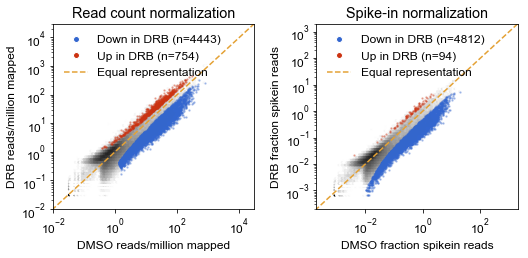

In [22]:
fig, ax = plt.subplots(figsize=(7.5,3.75), ncols = 2)
up_color = '#cc3311'
down_color = '#3366cf'

ax[0].hexbin(mean_norm_counts(read_counts_dmso, 'dmso'), 
          mean_norm_counts(read_counts_dmso, 'drb'), 
          cmap = 'Greys', bins = 'log', xscale = 'log',
          yscale = 'log'
         )

ax[1].hexbin(mean_norm_counts(read_counts_dmso, 'dmso', norm_type='spikein'), 
          mean_norm_counts(read_counts_dmso, 'drb', norm_type='spikein'), 
          cmap = 'Greys', bins = 'log', xscale = 'log',
          yscale = 'log'
         )

mask_up = (dmso_calls_total_norm.padj < 0.01) & (dmso_calls_total_norm.log2FoldChange > 0) & (dmso_calls_total_norm.index.isin(filtered_peaks.name))
mask_down = (dmso_calls_total_norm.padj < 0.01) & (dmso_calls_total_norm.log2FoldChange < 0) & (dmso_calls_total_norm.index.isin(filtered_peaks.name))
mask_up_norm = (dmso_calls_spikein_norm.padj < 0.01) & (dmso_calls_spikein_norm.log2FoldChange > 0) & (dmso_calls_spikein_norm.index.isin(filtered_peaks.name))
mask_down_norm = (dmso_calls_spikein_norm.padj < 0.01) & (dmso_calls_spikein_norm.log2FoldChange < 0) & (dmso_calls_spikein_norm.index.isin(filtered_peaks.name))

ax[0].scatter(mean_norm_counts(read_counts_dmso, 'dmso')[mask_up],
              mean_norm_counts(read_counts_dmso, 'drb')[mask_up],
              color = up_color, label = f'Up in DRB (n={mask_up.sum()})', s = 2, alpha=0.3,
              rasterized = True
             )

ax[0].scatter(mean_norm_counts(read_counts_dmso, 'dmso')[mask_down],
              mean_norm_counts(read_counts_dmso, 'drb')[mask_down],
              color = down_color, label = f'Down in DRB (n={mask_down.sum()})', s = 2, alpha=0.3, rasterized = True
             )

ax[1].scatter(mean_norm_counts(read_counts_dmso, 'dmso', norm_type='spikein')[mask_up_norm],
              mean_norm_counts(read_counts_dmso, 'drb', norm_type='spikein')[mask_up_norm],
              color = up_color, label = f'Up in DRB (n={mask_up_norm.sum()})', s = 2, alpha=0.3, rasterized = True
             )

ax[1].scatter(mean_norm_counts(read_counts_dmso, 'dmso', norm_type='spikein')[mask_down_norm],
              mean_norm_counts(read_counts_dmso, 'drb', norm_type='spikein')[mask_down_norm],
              color = down_color, label = f'Down in DRB (n={mask_down_norm.sum()})', s = 2, alpha=0.3,rasterized = True
             )


for a in ax:
    a.plot([0,1e5], [0, 1e5], color = '#E4A134', linestyle='--', label = 'Equal representation')

_, ax_0_labels = ax[0].get_legend_handles_labels()
_, ax_1_labels = ax[1].get_legend_handles_labels()

legend_handles = [
    _[0],
    mpl.lines.Line2D([0], [0], marker = 'o', markerfacecolor = up_color, color = 'w'),
    mpl.lines.Line2D([0], [0], marker = 'o', markerfacecolor = down_color, color = 'w')
]

ax[0].legend(frameon=False, handles = legend_handles[::-1], labels = ax_0_labels[::-1], loc = 'upper left')
ax[1].legend(frameon=False, handles = legend_handles[::-1], labels = ax_1_labels[::-1], loc = 'upper left')


ax[0].set_xlabel('DMSO reads/million mapped')
ax[0].set_ylabel('DRB reads/million mapped')
    
ax[0].set_xlim(1e-2, 3e4)
ax[0].set_ylim(1e-2, 3e4)

ax[1].set_xlabel('DMSO fraction spikein reads')
ax[1].set_ylabel('DRB fraction spikein reads')

ax[1].set_xlim(2e-4, 2e3)
ax[1].set_ylim(2e-4, 2e3)

ax[0].set_title('Read count normalization')
ax[1].set_title('Spike-in normalization')
fig.tight_layout()
fig.savefig('Read_count_vs_spikein_norm_deseq_calls.png', dpi=150)
fig.savefig('Read_count_vs_spikein_norm_deseq_calls.svg')
fig.savefig('Read_count_vs_spikein_norm_deseq_calls_low_res.svg', dpi=300)

(0.01, 50.0)

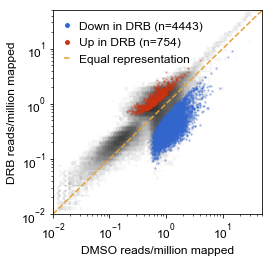

In [60]:
fig, ax = plt.subplots(figsize=(3.75,3.75))
ax.hexbin(mean_norm_counts_length(read_counts_dmso, 'dmso'), 
          mean_norm_counts_length(read_counts_dmso, 'drb'), 
          cmap = 'Greys', bins = 'log', xscale = 'log',
          yscale = 'log'
         )

ax.scatter(mean_norm_counts_length(read_counts_dmso, 'dmso')[mask_up],
              mean_norm_counts_length(read_counts_dmso, 'drb')[mask_up],
              color = up_color, label = f'Up in DRB (n={mask_up.sum()})', s = 2, alpha=0.3,
              rasterized = True
             )

ax.scatter(mean_norm_counts_length(read_counts_dmso, 'dmso')[mask_down],
              mean_norm_counts_length(read_counts_dmso, 'drb')[mask_down],
              color = down_color, label = f'Down in DRB (n={mask_down.sum()})', s = 2, alpha=0.3, rasterized = True
             )

ax.plot([0,1e5], [0, 1e5], color = '#E4A134', linestyle='--', label = 'Equal representation')

handles , ax_0_labels = ax.get_legend_handles_labels()

legend_handles = [
    handles[0],
    mpl.lines.Line2D([0], [0], marker = 'o', markerfacecolor = up_color, color = 'w'),
    mpl.lines.Line2D([0], [0], marker = 'o', markerfacecolor = down_color, color = 'w')
]

ax.legend(frameon=False, 
          handles = legend_handles[::-1], 
          labels = ax_0_labels[::-1], 
          loc = 'upper left',
          handlelength = 0.5
         )


ax.set_xlabel('DMSO reads/million mapped')
ax.set_ylabel('DRB reads/million mapped')
    
ax.set_xlim(1e-2, 5e1)
ax.set_ylim(1e-2, 5e1)


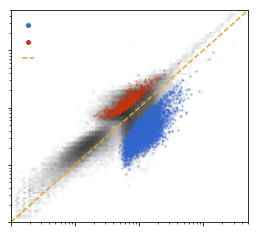

In [61]:
fig, ax = plt.subplots(figsize=(3.75,3.4))
ax.hexbin(mean_norm_counts_length(read_counts_dmso, 'dmso'), 
          mean_norm_counts_length(read_counts_dmso, 'drb'), 
          cmap = 'Greys', bins = 'log', xscale = 'log',
          yscale = 'log'
         )

ax.scatter(mean_norm_counts_length(read_counts_dmso, 'dmso')[mask_up],
              mean_norm_counts_length(read_counts_dmso, 'drb')[mask_up],
              color = up_color, label = f'Up in DRB (n={mask_up.sum()})', s = 2, alpha=0.3,
              rasterized = True
             )

ax.scatter(mean_norm_counts_length(read_counts_dmso, 'dmso')[mask_down],
              mean_norm_counts_length(read_counts_dmso, 'drb')[mask_down],
              color = down_color, label = f'Down in DRB (n={mask_down.sum()})', s = 2, alpha=0.3, rasterized = True
             )

ax.plot([0,1e5], [0, 1e5], color = '#E4A134', linestyle='--', label = 'Equal representation')

handles , ax_0_labels = ax.get_legend_handles_labels()

legend_handles = [
    handles[0],
    mpl.lines.Line2D([0], [0], marker = 'o', markerfacecolor = up_color, color = 'w'),
    mpl.lines.Line2D([0], [0], marker = 'o', markerfacecolor = down_color, color = 'w')
]

ax.legend(frameon=False, 
          handles = legend_handles[::-1], 
          labels = ['']*3, 
          loc = 'upper left',
          handlelength = 1.0
         )


ax.set_xlim(1e-2, 5e1)
ax.set_ylim(1e-2, 5e1)
# Get rid of x- and y-axis labels
ax.set_ylabel('')
ax.set_xlabel('')
# A little tricky: [''] * N (where N is an integer) will make a list of N empty strings (try it out!)
# So we're getting the number of ticks with len(ax.get_xticklabels()) and then
# just creating a new list with empty labels
ax.set_xticklabels([''] * len(ax.get_xticklabels()))
ax.set_yticklabels([''] * len(ax.get_yticklabels()))

fig.tight_layout()
fig.savefig('RPM_norm_no_labels.svg', transparent=True)

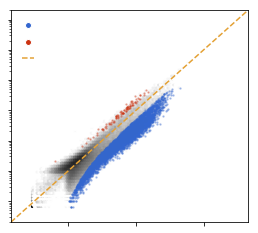

In [41]:
fig, ax = plt.subplots(figsize=(3.75,3.4))
ax.hexbin(mean_norm_counts_length(read_counts_dmso, 'dmso', norm_type='spikein'), 
          mean_norm_counts_length(read_counts_dmso, 'drb', norm_type='spikein'), 
          cmap = 'Greys', bins = 'log', xscale = 'log',
          yscale = 'log'
         )

ax.scatter(mean_norm_counts_length(read_counts_dmso, 'dmso', norm_type='spikein')[mask_up_norm],
              mean_norm_counts_length(read_counts_dmso, 'drb', norm_type='spikein')[mask_up_norm],
              color = up_color, label = f'Up in DRB (n={mask_up_norm.sum()})', s = 2, alpha=0.3, rasterized = True
             )

ax.scatter(mean_norm_counts_length(read_counts_dmso, 'dmso', norm_type='spikein')[mask_down_norm],
              mean_norm_counts_length(read_counts_dmso, 'drb', norm_type='spikein')[mask_down_norm],
              color = down_color, label = f'Down in DRB (n={mask_down_norm.sum()})', s = 2, alpha=0.3,rasterized = True
             )


ax.plot([0,1e5], [0, 1e5], color = '#E4A134', linestyle='--', label = 'Equal representation')

handles , ax_0_labels = ax.get_legend_handles_labels()

legend_handles = [
    handles[0],
    mpl.lines.Line2D([0], [0], marker = 'o', markerfacecolor = up_color, color = 'w'),
    mpl.lines.Line2D([0], [0], marker = 'o', markerfacecolor = down_color, color = 'w')
]

ax.legend(frameon=False, 
          handles = legend_handles[::-1], 
          labels = ['']*3, 
          loc = 'upper left',
          handlelength = 1.0
         )


ax.set_xlim(2e-4, 2e3)
ax.set_ylim(2e-4, 2e3)
# Get rid of x- and y-axis labels
ax.set_ylabel('')
ax.set_xlabel('')
# A little tricky: [''] * N (where N is an integer) will make a list of N empty strings (try it out!)
# So we're getting the number of ticks with len(ax.get_xticklabels()) and then
# just creating a new list with empty labels
ax.set_xticklabels([''] * len(ax.get_xticklabels()))
ax.set_yticklabels([''] * len(ax.get_yticklabels()))

fig.tight_layout()
fig.savefig('RPS_norm_no_labels.svg',transparent=True)

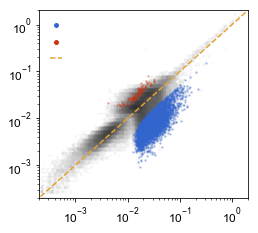

In [63]:
fig, ax = plt.subplots(figsize=(3.75,3.4))
ax.hexbin(mean_norm_counts_length(read_counts_dmso, 'dmso', norm_type='spikein'), 
          mean_norm_counts_length(read_counts_dmso, 'drb', norm_type='spikein'), 
          cmap = 'Greys', bins = 'log', xscale = 'log',
          yscale = 'log'
         )

ax.scatter(mean_norm_counts_length(read_counts_dmso, 'dmso', norm_type='spikein')[mask_up_norm],
              mean_norm_counts_length(read_counts_dmso, 'drb', norm_type='spikein')[mask_up_norm],
              color = up_color, label = f'Up in DRB (n={mask_up_norm.sum()})', s = 2, alpha=0.3, rasterized = True
             )

ax.scatter(mean_norm_counts_length(read_counts_dmso, 'dmso', norm_type='spikein')[mask_down_norm],
              mean_norm_counts_length(read_counts_dmso, 'drb', norm_type='spikein')[mask_down_norm],
              color = down_color, label = f'Down in DRB (n={mask_down_norm.sum()})', s = 2, alpha=0.3,rasterized = True
             )


ax.plot([0,1e5], [0, 1e5], color = '#E4A134', linestyle='--', label = 'Equal representation')

handles , ax_0_labels = ax.get_legend_handles_labels()

legend_handles = [
    handles[0],
    mpl.lines.Line2D([0], [0], marker = 'o', markerfacecolor = up_color, color = 'w'),
    mpl.lines.Line2D([0], [0], marker = 'o', markerfacecolor = down_color, color = 'w')
]

ax.legend(frameon=False, 
          handles = legend_handles[::-1], 
          labels = ['']*3, 
          loc = 'upper left',
          handlelength = 1.0
         )


ax.set_xlim(2e-4, 2e0)
ax.set_ylim(2e-4, 2e0)
# Get rid of x- and y-axis labels
ax.set_ylabel('')
ax.set_xlabel('')
# A little tricky: [''] * N (where N is an integer) will make a list of N empty strings (try it out!)
# So we're getting the number of ticks with len(ax.get_xticklabels()) and then
# just creating a new list with empty labels

fig.tight_layout()
fig.savefig('RPS_norm.svg',transparent=True)

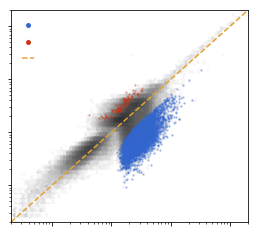

In [62]:
fig, ax = plt.subplots(figsize=(3.75,3.4))
ax.hexbin(mean_norm_counts_length(read_counts_dmso, 'dmso', norm_type='spikein'), 
          mean_norm_counts_length(read_counts_dmso, 'drb', norm_type='spikein'), 
          cmap = 'Greys', bins = 'log', xscale = 'log',
          yscale = 'log'
         )

ax.scatter(mean_norm_counts_length(read_counts_dmso, 'dmso', norm_type='spikein')[mask_up_norm],
              mean_norm_counts_length(read_counts_dmso, 'drb', norm_type='spikein')[mask_up_norm],
              color = up_color, label = f'Up in DRB (n={mask_up_norm.sum()})', s = 2, alpha=0.3, rasterized = True
             )

ax.scatter(mean_norm_counts_length(read_counts_dmso, 'dmso', norm_type='spikein')[mask_down_norm],
              mean_norm_counts_length(read_counts_dmso, 'drb', norm_type='spikein')[mask_down_norm],
              color = down_color, label = f'Down in DRB (n={mask_down_norm.sum()})', s = 2, alpha=0.3,rasterized = True
             )


ax.plot([0,1e5], [0, 1e5], color = '#E4A134', linestyle='--', label = 'Equal representation')

handles , ax_0_labels = ax.get_legend_handles_labels()

legend_handles = [
    handles[0],
    mpl.lines.Line2D([0], [0], marker = 'o', markerfacecolor = up_color, color = 'w'),
    mpl.lines.Line2D([0], [0], marker = 'o', markerfacecolor = down_color, color = 'w')
]

ax.legend(frameon=False, 
          handles = legend_handles[::-1], 
          labels = ['']*3, 
          loc = 'upper left',
          handlelength = 1.0
         )


ax.set_xlim(2e-4, 2e0)
ax.set_ylim(2e-4, 2e0)
# Get rid of x- and y-axis labels
ax.set_ylabel('')
ax.set_xlabel('')
# A little tricky: [''] * N (where N is an integer) will make a list of N empty strings (try it out!)
# So we're getting the number of ticks with len(ax.get_xticklabels()) and then
# just creating a new list with empty labels
ax.set_xticklabels([''] * len(ax.get_xticklabels()))
ax.set_yticklabels([''] * len(ax.get_yticklabels()))

fig.tight_layout()
fig.savefig('RPS_norm_no_labels.svg',transparent=True)

In [28]:
?ax.legend

In [ ]:
ax[0].legend(frameon=False, handles = legend_handles[::-1], labels = ax_0_labels[::-1], loc = 'upper left')


ax[0].set_xlabel('DMSO reads/million mapped')
ax[0].set_ylabel('DRB reads/million mapped')
    
ax[0].set_xlim(1e-2, 3e4)
ax[0].set_ylim(1e-2, 3e4)


In [ ]:
!echo $(whoami)@$HOSTNAME:$(pwd)

In [22]:
calls = dmso_calls_spikein_norm[dmso_calls_total_norm.index.isin(filtered_peaks.name)]

In [23]:
sig_down = calls[(calls.baseMean > 200) & (calls.padj < 1e-10)].sort_values('log2FoldChange')

In [24]:
for region, row in sig_down.iloc[11:20, :].iterrows():
    print(f"{region}, baseMean {row.baseMean} and l2FC {row.log2FoldChange}")

chr20:1436882-1466828, baseMean 1077.1733508258098 and l2FC -3.2544550427391803
chr13:106487759-106535639, baseMean 3042.1697972174497 and l2FC -3.24467816444481
chr1:241611307-241640297, baseMean 1425.1816644765 and l2FC -3.23854962475847
chr2:39729935-39779246, baseMean 2414.8022223631697 and l2FC -3.2275343728989703
chr2:95083619-95113755, baseMean 1042.02441552685 and l2FC -3.2169161431895796
chr2:54964344-54987933, baseMean 787.874329065465 and l2FC -3.2128855515114396
chr6:163415477-163477005, baseMean 2253.56812192303 and l2FC -3.19092732971985
chr1:198862837-198937424, baseMean 4694.36810164796 and l2FC -3.1815844921439904
chr10:101060301-101067989, baseMean 285.69026822632003 and l2FC -3.17570940534622


In [25]:
calls[(calls.baseMean > 200) & (calls.log2FoldChange > 0) & (calls.padj < 0.01)].sort_values('log2FoldChange', ascending=False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
chr14:63352633-63380807,1438.022799,1.657856,0.248180,6.680061,2.388433e-11,1.706052e-09
chr6:163551810-163589803,2677.730116,1.633253,0.240691,6.785683,1.155388e-11,8.761947e-10
chr12:112231726-112243169,211.900700,1.560335,0.292214,5.339703,9.309898e-08,3.244801e-06
chr2:238398663-238414969,335.008762,1.462547,0.279492,5.232884,1.668853e-07,5.514912e-06
chr4:109538504-109559252,841.029535,1.425840,0.273597,5.211452,1.873682e-07,6.125242e-06
chr3:179776229-179807859,1817.386074,1.399269,0.255283,5.481253,4.223236e-08,1.580614e-06
chr12:39277165-39306351,888.333194,1.390406,0.263705,5.272588,1.345132e-07,4.531522e-06
chr16:68223905-68236711,622.621216,1.388478,0.261692,5.305771,1.121977e-07,3.853128e-06
chr5:109839530-109885858,1880.736345,1.387455,0.247878,5.597329,2.176798e-08,8.619684e-07
chr2:179092095-179131093,1731.048094,1.349078,0.257881,5.231392,1.682380e-07,5.553262e-06


In [26]:
calls[(calls.baseMean > 200) & (calls.log2FoldChange > 0) & (calls.padj < 0.01)].sort_values('log2FoldChange', ascending=False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
chr14:63352633-63380807,1438.022799,1.657856,0.248180,6.680061,2.388433e-11,1.706052e-09
chr6:163551810-163589803,2677.730116,1.633253,0.240691,6.785683,1.155388e-11,8.761947e-10
chr12:112231726-112243169,211.900700,1.560335,0.292214,5.339703,9.309898e-08,3.244801e-06
chr2:238398663-238414969,335.008762,1.462547,0.279492,5.232884,1.668853e-07,5.514912e-06
chr4:109538504-109559252,841.029535,1.425840,0.273597,5.211452,1.873682e-07,6.125242e-06
chr3:179776229-179807859,1817.386074,1.399269,0.255283,5.481253,4.223236e-08,1.580614e-06
chr12:39277165-39306351,888.333194,1.390406,0.263705,5.272588,1.345132e-07,4.531522e-06
chr16:68223905-68236711,622.621216,1.388478,0.261692,5.305771,1.121977e-07,3.853128e-06
chr5:109839530-109885858,1880.736345,1.387455,0.247878,5.597329,2.176798e-08,8.619684e-07
chr2:179092095-179131093,1731.048094,1.349078,0.257881,5.231392,1.682380e-07,5.553262e-06


In [27]:
calls[(calls.baseMean > 200)  & (calls.log2FoldChange.abs() < 0.01)].sort_values('baseMean')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
chr10:72996557-73006461,260.349108,-0.003963,0.326215,-0.012148,0.990307,0.997408
chr5:93620268-93630702,282.846682,-0.004417,0.282769,-0.015620,0.987538,0.996661
chr13:50072052-50082201,288.744913,0.009611,0.345751,0.027796,0.977824,0.993755
chr7:80221343-80232858,301.433864,-0.002317,0.306372,-0.007563,0.993965,0.998485
chr3:197054214-197067539,306.078233,-0.009432,0.274291,-0.034388,0.972568,0.992335
chr11:14595163-14607098,316.521225,-0.008414,0.283520,-0.029676,0.976326,0.993396
chrX:132663588-132679374,335.959078,-0.001231,0.298421,-0.004125,0.996709,0.999130
chr9:6977959-6989347,340.015337,0.008777,0.280113,0.031335,0.975002,0.993069
chr4:151626343-151641358,355.283730,-0.006812,0.279516,-0.024369,0.980558,0.994622
chr3:115002438-115021073,393.055737,0.000474,0.279673,0.001695,0.998647,0.999645


In [28]:
unchanged = calls[(calls.baseMean > 200)  & (calls.log2FoldChange.abs() < 0.01)].sort_values('baseMean').index

In [30]:
dmso_calls_total_norm[dmso_calls_total_norm.index.isin(unchanged)]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
chr1:61256457-61324181,2635.072779,0.274712,0.171487,1.601946,0.109167,0.259449
chr1:178355424-178463046,3316.336626,0.281134,0.168791,1.665572,0.095799,0.240243
chr10:20152677-20187302,879.247434,0.276238,0.182507,1.513576,0.130133,0.288049
chr10:34494759-34517573,410.217453,0.280335,0.201129,1.393809,0.163375,0.328865
chr10:72996557-73006461,252.721068,0.294779,0.237866,1.239263,0.215248,0.384091
chr11:14595163-14607098,310.703879,0.254154,0.209992,1.210306,0.226162,0.394938
chr11:43477123-43496100,390.011745,0.273420,0.202240,1.351962,0.176388,0.342853
chr11:108330757-108363281,841.981470,0.255006,0.184434,1.382637,0.166776,0.332588
chr12:10800724-10902510,3255.989872,0.278886,0.177827,1.568299,0.116811,0.270618
chr13:50072052-50082201,285.367131,0.254164,0.482961,0.526261,0.598707,0.711018
